# CSGY 6953 Deep Learning Final Project
In this project, we will implement a dual-encoder model for image search. In particular, our model will be fed a text query and will return several images that are related to the query. To do this task, our model will be trained so that it embeds both image and text data into the same space, and importantly, encodes relevant data to be close each other in the embedding space. This will be done by developing two encoders, one for image processing and the other for text encoding, and training them by a similarity-based loss function. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import tqdm
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
with open(f"drive/My Drive/finalproj/data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

In [4]:
train_pct = 0.7
threshold = int(len(dataset["images"]) * train_pct)
train_images = dataset["images"][:threshold]
train_texts = dataset["texts"][:threshold * 10]
test_images = dataset["images"][threshold:]
test_texts = dataset["texts"][threshold * 10:]
print(f"Training images: ", len(train_images))
print(f"Training texts: ", len(train_texts))
print(f"Test images: ", len(test_images))
print(f"Test texts: ", len(test_texts))

Training images:  3150
Training texts:  31500
Test images:  1350
Test texts:  13500


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchtext
!pip install transformers
from transformers import BertModel, BertTokenizerFast
!pip install timm
import timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device is " + device.type + ".")

The device is cuda.


## Encoders
Encoders denote the pretrained part of the network. In both image and text encoders, they returns an 1-D array. This is fed into fully connected layers having trainable parameters before computing the similarity. This FC layers will be defined separately, which we call Encoder Head. <br>
<br>
Encoder class must have
* Pretrained model and forward function.
* self.output_size: the size of the 1-D array. (This may be a tuple in the later step when we fine-tune the output of the language models.)
* self.num_parameters: This is not necessary but we store the number of pretrained parameters here.

In [7]:
class InceptionV3Encoder(torch.nn.Module):
    def __init__(self):
        super(InceptionV3Encoder, self).__init__()

        self.incep3 = torchvision.models.inception_v3(pretrained=True)
        self.incep3.aux_logits = False # We don't use the auxiliary output.
        self.output_size = self.incep3.fc.in_features # in_features=2048.
        self.incep3.fc = torch.nn.Identity() # Deactivate the fc layer. torch.nn.Identity has no parameters.
        for parameter in self.incep3.parameters():
            parameter.requires_grad = False # Freeze all the parameters.
        self.num_parameters = sum([np.prod(params.size()) for params in self.incep3.parameters()])

    def forward(self, x):
        return self.incep3(x)

class XceptionEncoder(torch.nn.Module):
    def __init__(self):
        super(XceptionEncoder, self).__init__()

        self.xception = timm.create_model("xception", pretrained=True)
        self.output_size = self.xception.fc.in_features
        self.xception.fc = torch.nn.Identity()
        for parameter in self.xception.parameters():
            parameter.requires_grad = False
        self.num_parameters = sum([np.prod(params.size()) for params in self.xception.parameters()])
    
    def forward(self, x):
        return self.xception(x)

class ResNetEncoder(torch.nn.Module):
    def __init__(self):
        super(ResNetEncoder, self).__init__()

        self.resnet = torchvision.models.resnet101(pretrained=True, progress=False)
        self.output_size = self.resnet.fc.in_features
        self.resnet.fc = torch.nn.Identity()
        for parameter in self.resnet.parameters():
            parameter.requires_grad = False
        self.num_parameters = sum([np.prod(params.size()) for params in self.resnet.parameters()])
    
    def forward(self, x):
        return self.resnet(x)

class BertEncoder(torch.nn.Module):
    def __init__(self):
        super(BertEncoder, self).__init__()

        self.bert = BertModel.from_pretrained("bert-base-uncased", output_attentions=False) 
        # With bert-base-uncased, all the input are lowercased before being tokenized.
        self.output_size = self.bert.config.hidden_size # hidden_size=768.
        for parameter in self.bert.parameters():
            parameter.requires_grad = False # Freeze all the parameters.
        self.num_parameters = sum([np.prod(params.size()) for params in self.bert.parameters()])
    
    def forward(self, input_ids, attention_mask):
        last_hidden, _ = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        return last_hidden[:, 0]

class GloVeEncoder(torch.nn.Module):
    # No pre-trained nets are used for GloVe Word2Vec. RNN part is trainable.
    def __init__(self):
        super(GloVeEncoder, self).__init__()

        self.glove = torch.nn.Identity()
        self.output_size = [None, 50] # [max_len, word embedding dimension]
        self.num_parameters = 0
    
    def forward(self, embeddings):
        return self.glove(embeddings)

def Encoder(name):
    if name == "InceptionV3":
        return InceptionV3Encoder()
    elif name == "Xception":
        return XceptionEncoder()
    elif name == "ResNet":
        return ResNetEncoder()
    elif name == "BERT":
        return BertEncoder()
    elif name == "GloVe":
        return GloVeEncoder()
    else:
        raise ValueError(name + " has not been implemented!")

## Encoder Head
Encoder Heads are defined as follows. While our Encoders have only pretrained parameters, which are freezed during the training, all the parameters in Encoder Heads are trainable. Usually, they consists of one or more fully connected layers. <br>
<br>
Encoder Head class must have
* Trainable model and forward function.
* self.num_parameters: This is not necessary but we store the number of trainable parameters here.

In [8]:
class FullyConnectedEncoderHead(torch.nn.Module):
    def __init__(self, input_dim, embed_dim=128):
        super(FullyConnectedEncoderHead, self).__init__()

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, embed_dim),
            torch.nn.Tanh()
        )
        self.num_parameters = sum([np.prod(params.size()) for params in self.fc.parameters()])

    def forward(self, x):
        return self.fc(x)

class BiLSTMEncoderHead(torch.nn.Module):
    def __init__(self, input_dim, embed_dim=128):
        super(BiLSTMEncoderHead, self).__init__()

        self.lstm_hidden_size = 150
        self.lstm_num_layers = 1
        self.lstm = torch.nn.LSTM(input_size = input_dim[1], 
                                  hidden_size=self.lstm_hidden_size, 
                                  num_layers=self.lstm_num_layers, 
                                  bidirectional=True)
        self.fc = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.Linear(2 * self.lstm_hidden_size, embed_dim),
            torch.nn.Tanh()
        )
        self.num_parameters = sum([np.prod(params.size()) for params in self.lstm.parameters()])
        self.num_parameters += sum([np.prod(params.size()) for params in self.fc.parameters()])

    def forward(self, x):
        batch_size = x.shape[1]
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        h_0 = torch.zeros(2 * self.lstm_num_layers, batch_size, self.lstm_hidden_size).to(device)
        c_0 = torch.zeros(2 * self.lstm_num_layers, batch_size, self.lstm_hidden_size).to(device)
        lstm_out, (_, _) = self.lstm(x, (h_0, c_0))
        fc_input = torch.cat((lstm_out[:, -1, :self.lstm_hidden_size], lstm_out[:, 0, self.lstm_hidden_size:]), dim=1)
        # The first tensor corresponds to normal LSTM, the second corresponds to reverse LSTM.
        return self.fc(fc_input)

def EncoderHead(name, input_dim, embed_dim=128):
    if name == "FC":
        if isinstance(input_dim, list):
            raise TypeError("Pretrained encoder and encoder head are not compatible.")
        return FullyConnectedEncoderHead(input_dim, embed_dim)
    elif name == "BiLSTM":
        if not isinstance(input_dim, list):
            raise TypeError("Pretrained encoder and encoder head are not compatible.")
        return BiLSTMEncoderHead(input_dim, embed_dim)
    else:
        raise ValueError(name + " has not been implemented!")

## Preprocessors
The original dataset has lists of numbers and texts. To feed them into our Encoders, we need to preprocess them into the required form. This work is done by Preprocessors.

In [9]:
class ImagePreprocessor():
    def process(self, x):
        return torch.swapaxes(torch.swapaxes(x / 255.0, 3, 2), 2, 1)

class BertPreprocessor():
    def __init__(self, max_len=50):
        self.max_len = max_len
        self.tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", model_max_length=self.max_len)
    
    def process(self, x):
        padded_list = self.tokenizer.batch_encode_plus(x, padding=True)
        input_ids = torch.LongTensor(np.array(padded_list["input_ids"])) # It looks like bypassing numpy is faster.
        attention_mask = torch.LongTensor(np.array(padded_list["attention_mask"]))
        return input_ids, attention_mask

class GloVePreprocessor():
    def __init__(self, max_len=50):
        self.max_len = max_len
        self.tokenizer = torchtext.data.get_tokenizer("basic_english")
        self.GloVe = torchtext.vocab.GloVe(name="6B", dim=50)
    
    def process(self, x):
        tokens = [self.tokenizer(text) for text in x]
        tokens = [token + [""] * (self.max_len - len(token)) if len(token) < self.max_len else token[:self.max_len] for token in tokens]
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        embeddings = torch.zeros(len(x), self.max_len, 50).to(device)
        for i, token in enumerate(tokens):
            embeddings[i] = self.GloVe.get_vecs_by_tokens(token, lower_case_backup=True)
        return embeddings, None

def Preprocessor(name, max_len=70):
    if name in ["InceptionV3", "Xception", "ResNet"]:
        return ImagePreprocessor()
    elif name in ["BERT"]:
        return BertPreprocessor(max_len)
    elif name in ["GloVe"]:
        return GloVePreprocessor(max_len)
    else:
        raise ValueError(name + " has not been implemented!")

## Dataset 
To use the DataLoader, we need the following DualEncoderDataset class. It does
* Preprocess the data and store the output of Encoders.
* Create the positive and negative pairs of an image and a text.
* neg_rate controls the rate of negative pairs. For each positive pair, it generates neg_rate negative pairs.

In [10]:
class DualEncoderDataset(Dataset):
    def __init__(self, images, texts, device, image_model, text_model, max_len=70, neg_rate=4, preprocessing_batch_size=32):
        self.num_images = len(images)
        self.num_texts = len(texts)
        self.image_text_rate = int(self.num_texts / self.num_images)
        self.num_negative = int(self.num_texts * neg_rate)
        self.random_map = []
        self.shuffle()

        print("\nPreprocessing image data...")
        self.imagedata_preprocessed = []
        image_encoder = Encoder(image_model).to(device)
        image_preprocessor = Preprocessor(image_model)
        num_batches = math.ceil(self.num_images / preprocessing_batch_size)
        for i in tqdm.tqdm(range(num_batches)):
            if i < num_batches - 1:
                image_batch = images[i * preprocessing_batch_size : (i + 1) * preprocessing_batch_size]
            else:
                image_batch = images[i * preprocessing_batch_size :]
            image_batch = torch.FloatTensor(np.array(image_batch)).to(device)
            self.imagedata_preprocessed += image_encoder(image_preprocessor.process(image_batch)).tolist()
        self.image_encoder_num_parameters = image_encoder.num_parameters
        self.image_encoder_output_size = image_encoder.output_size

        print("Preprocessing text data...")
        self.textdata_preprocessed = []
        text_encoder = Encoder(text_model).to(device)
        text_preprocessor = Preprocessor(text_model, max_len)
        num_batches = math.ceil(self.num_texts / preprocessing_batch_size)
        for i in tqdm.tqdm(range(num_batches)):
            if i < num_batches - 1:
                text_batch = texts[i * preprocessing_batch_size : (i + 1) * preprocessing_batch_size]
            else:
                text_batch = texts[i * preprocessing_batch_size :]
            text_batch, attention_batch = text_preprocessor.process(text_batch)
            text_batch = text_batch.to(device)
            if attention_batch is not None:
                attention_batch = attention_batch.to(device)
                self.textdata_preprocessed += text_encoder(text_batch, attention_batch).tolist()
            else:
                self.textdata_preprocessed += text_encoder(text_batch).tolist()
        self.text_encoder_num_parameters = text_encoder.num_parameters
        self.text_encoder_output_size = text_encoder.output_size

    def shuffle(self):
        self.random_map = np.random.randint(0, self.num_texts - self.image_text_rate, self.num_negative)
        for i in range(self.num_negative):
            if self.random_map[i] >= i % self.num_texts // self.image_text_rate * self.image_text_rate:
                self.random_map[i] += self.image_text_rate
    
    def set_neg_rate(self, neg_rate):
        self.num_negative = int(self.num_texts * neg_rate)
        self.random_map = []
        self.shuffle()
    
    def print_num_params(self):
        print(f"\n=== Image Encoder ===")
        print(f"  Pretrained Parameters: {self.image_encoder_num_parameters:,}")
        print(f"\n=== Text Encoder ===")
        print(f"  Pretrained Parameters: {self.text_encoder_num_parameters:,}")
    
    def __len__(self):
        return self.num_texts + self.num_negative

    def __getitem__(self, sample_idx):
        if torch.is_tensor(sample_idx):
            sample_idx = sample_idx[0].tolist()
        image_idx = sample_idx % self.num_texts // self.image_text_rate
        image = self.imagedata_preprocessed[image_idx]
        image = torch.from_numpy(np.array(image)).to(torch.float32)

        if sample_idx < self.num_texts:
            text_idx = sample_idx
        else:
            text_idx = self.random_map[sample_idx - self.num_texts]
        text = self.textdata_preprocessed[text_idx]
        text = torch.from_numpy(np.array(text)).to(torch.float32)
        
        label = 1 if sample_idx < self.num_texts else -1
        label = torch.from_numpy(np.array(label)).to(torch.float32)

        sample = {"images": image, "texts": text, "labels": label, "image_idx": image_idx, "text_idx": text_idx}
        return sample

## Constructing Dataset
Set the parameters; embed_dim is the dimensionality of the embedding space, and max_len is the maximum length of the encoded text sequence. It takes time to construct the dataset because preprocessing and feed forwarding the pretrained nets are performed.

In [11]:
embed_dim = 256
max_len = 60 # Recommend: 46 for GloVe, 60 for BERT (though the maximum is 146)
image_encoder_model = "InceptionV3"
text_encoder_model = "BERT"
image_head_model = "FC"
text_head_model = "FC"

TrainingDataset = DualEncoderDataset(train_images, train_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TestDataset = DualEncoderDataset(test_images, test_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TrainingDataset.print_num_params()


Preprocessing image data...


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 99/99 [00:18<00:00,  5.49it/s]


Preprocessing text data...


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

100%|██████████| 985/985 [00:44<00:00, 22.18it/s]



Preprocessing image data...


100%|██████████| 43/43 [00:06<00:00,  7.16it/s]


Preprocessing text data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 422/422 [00:19<00:00, 21.76it/s]



=== Image Encoder ===
  Pretrained Parameters: 25,112,264

=== Text Encoder ===
  Pretrained Parameters: 109,482,240


## Encoder Heads, Loss Function, Optimizer
Recall that all the trainable parameters reside in Encoder Heads. We also set the loss function and optimizer for each Encoder Head.

In [12]:
image_head = EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
text_head = EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
print(f"=== Image Encoder Head ===")
print(f"  Trainable Parameters: {image_head.num_parameters:,}")
print(f"\n=== Text Encoder Head ===")
print(f"  Trainable Parameters: {text_head.num_parameters:,}")

criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005)
text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.0005)

=== Image Encoder Head ===
  Trainable Parameters: 1,180,416

=== Text Encoder Head ===
  Trainable Parameters: 525,056


## Training Function
Training and evaluation functions. As we set the CosineEmbeddingLoss with reduction="sum", all the loss are aggregated and divided by the number of samples at the end. <br>
With our naive algorithm to compute the Median Rank (MedR) and Recall at top K (R@K), it takes time to evaluate them. By setting only_loss=True, which is the default setting, we can skip the heavy load of computing MedR and R@K. <br>
sim_mat stores the cosine similarity between all the image-text pairs. It has a shape (# images * # texts).

In [13]:
def train():
    image_head.train()
    text_head.train()
    train_loss = 0
    num_samples = 0

    for batch in trainloader:
        image_optimizer.zero_grad()
        text_optimizer.zero_grad()
        image_embedding = image_head(batch["images"].to(device))
        text_embedding = text_head(batch["texts"].to(device))
        loss = criterion(image_embedding, text_embedding, batch["labels"].to(device))
        loss.backward()
        image_optimizer.step()
        text_optimizer.step()
        train_loss += loss.item()
        num_samples += batch["labels"].size(0)
    
    train_loss /= num_samples
    return train_loss

def eval(only_loss=True):
    image_head.eval()
    text_head.eval()
    eval_loss = 0
    num_samples = 0
    image_embeddings = [None for _ in range(TestDataset.num_images)]
    text_embeddings = [None for _ in range(TestDataset.num_texts)]
    with torch.no_grad():
        for batch in testloader:
            image_embedding = image_head(batch["images"].to(device))
            text_embedding = text_head(batch["texts"].to(device))
            for i in range(len(batch["image_idx"])):
                if image_embeddings[batch["image_idx"][i]] is None:
                    image_embedding_numpy = image_embedding[i].cpu().numpy()
                    image_embeddings[batch["image_idx"][i]] = image_embedding_numpy / np.linalg.norm(image_embedding_numpy, ord=2)
            for i in range(len(batch["text_idx"])):
                if text_embeddings[batch["text_idx"][i]] is None:
                    text_embedding_numpy = text_embedding[i].cpu().numpy()
                    text_embeddings[batch["text_idx"][i]] = text_embedding_numpy / np.linalg.norm(text_embedding_numpy, ord=2)
            loss = criterion(image_embedding, text_embedding, batch["labels"].to(device))
            eval_loss += loss.item()
            num_samples += batch["labels"].size(0)
    eval_loss /= num_samples

    if only_loss:
        sim_mat = None
    else: 
        image_embeddings = np.array(image_embeddings)
        text_embeddings = np.array(text_embeddings)
        sim_mat = np.dot(image_embeddings, text_embeddings.T)
    return eval_loss, sim_mat

def proj(dataset, batch_size=32):
    image_head.eval()
    text_head.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_num_batches = math.ceil(dataset.num_images / batch_size)
    text_num_batches = math.ceil(dataset.num_texts / batch_size)
    with torch.no_grad():
        for i in range(image_num_batches):
            if i < image_num_batches - 1:
                image_batch = dataset.imagedata_preprocessed[i * batch_size : (i + 1) * batch_size]
            else:
                image_batch = dataset.imagedata_preprocessed[i * batch_size :]
            image_batch = torch.FloatTensor(np.array(image_batch)).to(device)
            if i == 0:
                image_embeddings = image_head(image_batch).cpu().numpy()
            else:
                image_embeddings = np.vstack((image_embeddings, image_head(image_batch).cpu().numpy()))
        for i in range(text_num_batches):
            if i < text_num_batches - 1:
                text_batch = dataset.textdata_preprocessed[i * batch_size : (i + 1) * batch_size]
            else:
                text_batch = dataset.textdata_preprocessed[i * batch_size :]
            text_batch = torch.FloatTensor(np.array(text_batch)).to(device)
            if i == 0:
                text_embeddings = text_head(text_batch).cpu().numpy()
            else:
                text_embeddings = np.vstack((text_embeddings, text_head(text_batch).cpu().numpy()))
    return image_embeddings, text_embeddings

In [14]:
def getMedR(sim_mat):
    rank = np.argsort(-sim_mat, axis=0)
    rank = np.argsort(rank, axis=0)
    ranking = [rank[i, i * TestDataset.image_text_rate : (i + 1) * TestDataset.image_text_rate] for i in range(TestDataset.num_images)]
    ranking = np.array(ranking).flatten()
    image_MedR = np.median(ranking)
    rank = np.argsort(-sim_mat, axis=1)
    rank = np.argsort(rank, axis=1)
    ranking = [rank[i, i * TestDataset.image_text_rate : (i + 1) * TestDataset.image_text_rate] for i in range(TestDataset.num_images)]
    ranking = np.array(ranking).flatten()
    text_MedR = np.median(ranking)
    return {"image": image_MedR, "text": text_MedR}

def getRatK(sim_mat, K=10):
    rank = np.argsort(-sim_mat, axis=0)
    rank = np.argsort(rank, axis=0)
    ranking = [rank[i, i * TestDataset.image_text_rate : (i + 1) * TestDataset.image_text_rate] for i in range(TestDataset.num_images)]
    ranking = np.array(ranking).flatten()
    image_RatK = sum(ranking < K) / len(ranking)
    rank = np.argsort(-sim_mat, axis=1)
    rank = np.argsort(rank, axis=1)
    ranking = [rank[i, i * TestDataset.image_text_rate : (i + 1) * TestDataset.image_text_rate] for i in range(TestDataset.num_images)]
    ranking = np.array(ranking).flatten()
    text_RatK = sum(ranking < K) / len(ranking)
    return {"image": image_RatK, "text": text_RatK}

In [15]:
epochs = 20
batch_size = 128
train_loss = []
eval_loss = []
trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(TestDataset, batch_size=batch_size, shuffle=True)

print("Start Training...")
for epoch in range(epochs):
    trainloss = train()
    train_loss.append(trainloss)
    evalloss, _ = eval()
    eval_loss.append(evalloss)
    if (epoch + 1) % 2 == 0:
        print("Epoch: " + str(epoch + 1) + " | Training loss: " + str(round(trainloss, 4)) + " | Test loss: " + str(round(evalloss, 4)))
    # if (epoch + 1) % 4 == 0:
    #     TrainingDataset.shuffle()
    #     trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
    #     print("   Negative pairs shuffled after epoch " + str(epoch + 1))
_, sim_mat = eval(only_loss=False)

Start Training...
Epoch: 2 | Training loss: 0.1541 | Test loss: 0.1551
Epoch: 4 | Training loss: 0.0957 | Test loss: 0.1383
Epoch: 6 | Training loss: 0.0818 | Test loss: 0.1314
Epoch: 8 | Training loss: 0.0749 | Test loss: 0.1289
Epoch: 10 | Training loss: 0.0702 | Test loss: 0.1293
Epoch: 12 | Training loss: 0.0666 | Test loss: 0.1275
Epoch: 14 | Training loss: 0.064 | Test loss: 0.1264
Epoch: 16 | Training loss: 0.0615 | Test loss: 0.1259
Epoch: 18 | Training loss: 0.0599 | Test loss: 0.1248
Epoch: 20 | Training loss: 0.0581 | Test loss: 0.1238


Ideally in the heatmap, we want to have high values in diagonal entries and values less than margin (a parameter in CosineEmbeddingLoss) otherwise.

Image Retrieval From Text:
   Median Rank: 43.0 / 1350
   Recall at K: 0.195
Text Retrieval From Image:
   Median Rank: 440.0 / 13500
   Recall at K: 0.024


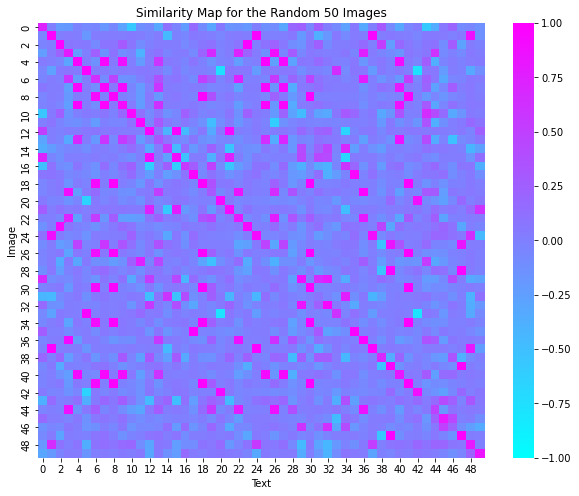

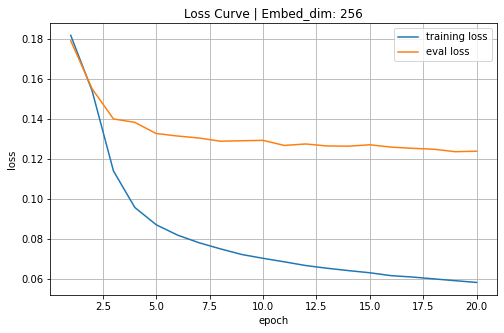

In [16]:
MedR = getMedR(sim_mat)
RatK = getRatK(sim_mat)
print("Image Retrieval From Text:")
print("   Median Rank: " + str(round(MedR["image"], 2)) + " / " + str(TestDataset.num_images))
print("   Recall at K: " + str(round(RatK["image"], 3)))
print("Text Retrieval From Image:")
print("   Median Rank: " + str(round(MedR["text"], 2)) + " / " + str(TestDataset.num_texts))
print("   Recall at K: " + str(round(RatK["text"], 3)))

num_show = 50
plt.figure(figsize=(10,8))
rand_idx = np.random.randint(0, len(sim_mat), num_show)
sns.heatmap(sim_mat[rand_idx][:, rand_idx * 10 + np.random.randint(0, 10, num_show)], cmap="cool", vmin=-1, vmax=1)
plt.title("Similarity Map for the Random " + str(num_show) + " Images")
plt.xlabel("Text")
plt.ylabel("Image")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(np.arange(1, epochs + 1), train_loss, label="training loss")
plt.plot(np.arange(1, epochs + 1), eval_loss, label="eval loss")
plt.title(f"Loss Curve | Embed_dim: {embed_dim}")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.show()

In [19]:
def TextFromImage(sim_mat, num_image=5, num_text=10):
    image_idx = np.random.randint(0, TestDataset.num_images, num_image)
    rank = np.argsort(-sim_mat, axis=1)
    for i in range(num_image):
        print("Query Image:")
        img = test_images[image_idx[i]]
        img = np.flip(img, axis=-1)
        plt.figure(figsize=(3, 3))
        plt.imshow(img)
        plt.show()
        for j in range(num_text):
            print(f"CosSim={sim_mat[image_idx[i], rank[image_idx[i], j]]:.4f} | " + test_texts[rank[image_idx[i], j]])
        print("\n")

def ImageFromText(sim_mat, num_text=5, num_image=10):
    text_idx = np.random.randint(0, TestDataset.num_texts, num_text)
    rank = np.argsort(-sim_mat, axis=0)
    for i in range(num_text):
        print("Query Text: " + test_texts[text_idx[i]])
        plt.figure(figsize=(20, 5))
        for j in range(num_image):
            plt.subplot(1, num_image, j + 1)
            img = test_images[rank[j, text_idx[i]]]
            img = np.flip(img, axis=-1)
            plt.imshow(img)
            plt.title(f"CosSim={sim_mat[rank[j, text_idx[i]], text_idx[i]]:.4f}")
        plt.tight_layout()
        plt.show()
        print("\n")

Query Image:


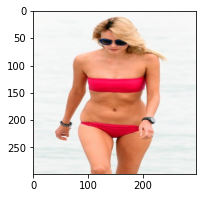

CosSim=0.9951 | Older woman wearing grey hat with gold accent in background with straw woven hat to the front left of her.
CosSim=0.9877 | A woman shows off her floral tattoos on her face. 
CosSim=0.9869 | Older woman dressed in trousers and open toe footwear standing outside.
CosSim=0.9850 | A woman poses while wearing different head scarves.
CosSim=0.9837 | Dark haired woman wearing necklace and white dress standing next to someone on suit.
CosSim=0.9811 | the backside of a woman in a black fur coat
CosSim=0.9800 | A woman is wearing a blue hat and a blue jacket.
CosSim=0.9792 | A woman is wearing a hat with a black stripe around it.
CosSim=0.9781 | A woman wearing red lipstick and a blue dress smiles for a photo.
CosSim=0.9773 | A woman wearing a short skirt and sleeveless top poses with her arms above her head.


Query Image:


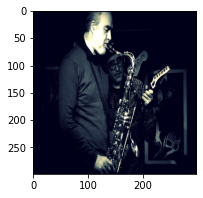

CosSim=0.9920 | A woman playing the harpsichord in a music hall. 
CosSim=0.9903 | A person is singing on a mic while playing on a keyboard.
CosSim=0.9892 | The person is standing around doing something with the piano.
CosSim=0.9890 | A middle age man is playing a saxophone in front of a microphone.
CosSim=0.9882 | A man playing a keyboard and wearing a blue scarf.
CosSim=0.9881 | A man with red and black clothes and black hair is playing a keyboard. 
CosSim=0.9876 | A man sitting at a keyboard and singing into a microphone.
CosSim=0.9874 | A man is playing the saxophone next to a man playing guitar.
CosSim=0.9872 | A man in glasses and white shirt holding and playing a saxophone.
CosSim=0.9865 | A man sitting at keyboards and singing into a microphone.


Query Image:


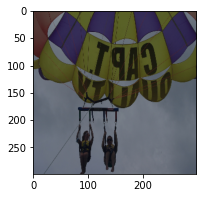

CosSim=0.8882 | A man looking at a bag behind a fence.
CosSim=0.8810 | A person is standing near the stairs and box
CosSim=0.8674 | A person carrying a baby while walking in a field.
CosSim=0.8608 | A person in a purple coat and a pink hat standing in a park.
CosSim=0.8604 | Man wearing a black hat is riding a horse with a little girl
CosSim=0.8578 | A small person holding an animated yellow bee
CosSim=0.8567 | A man wearing sunglasses and green clothing is holding a crab.
CosSim=0.8558 | A man standing outside in the grass holding a glass.

CosSim=0.8529 | A woman carrying a baby is walking through a sunflower garden.
CosSim=0.8502 | A person carrying an handbag and picking fruits into a leather bag 


Query Image:


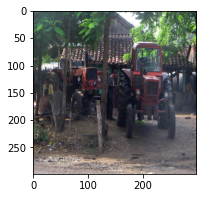

CosSim=0.9456 | A few motorcycles are on the street near several shops.
CosSim=0.9430 | Two golf carts are parked near the plants and trees.
CosSim=0.9401 | A bicycle gear  and  a  chain laying  in the  grass  
CosSim=0.9377 | A motorcycle with red and blue mainly and a camouflage tank. 
CosSim=0.9341 | Small orange and yellow three wheeled covered cart.
CosSim=0.9336 | A couple of tractors in front of a house. 
CosSim=0.9295 | Jeep with oversized wheels being driven over large rocks.
CosSim=0.9283 | A bicycle that is jumping in the air in the middle of the woods.
CosSim=0.9261 | A colorful two wheeled bicycle that is red with blue polka dots and cats on it.
CosSim=0.9237 | A motorized scooter with a small basket attached to the back of it.


Query Image:


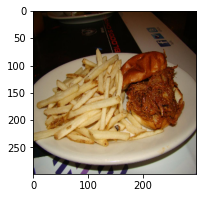

CosSim=0.9998 | Hamburger topped with onion, tomato, lettuce, and ketchup and fries on a blue plate.
CosSim=0.9997 | A salad with broccoli, tomatoes and cheese sits in a black bowl. 
CosSim=0.9997 | A plate of salad that has broccoli and tomatoes. 
CosSim=0.9997 | A tall sandwich with lettuce, onion, and cheese on a plate.
CosSim=0.9997 | A plate of food with shrimp and fruit topped with onions.
CosSim=0.9997 | A hamburger topped with onions, lettuce and tomatoes sits next to a plate of fries.
CosSim=0.9997 | Fresh tomato and mottzarella cheese salad with green onion and spinich garnish.
CosSim=0.9997 | A submarine sandwich with meat and vegetables on it.
CosSim=0.9997 | A tall sandwich has burgers, cheese, lettuce and tomato.
CosSim=0.9996 | Broccoli, bell pepper and tomato salad with feta cheese as a garnish.




In [20]:
TextFromImage(sim_mat)

Query Text: A vase with flowers is sitting on a table. 


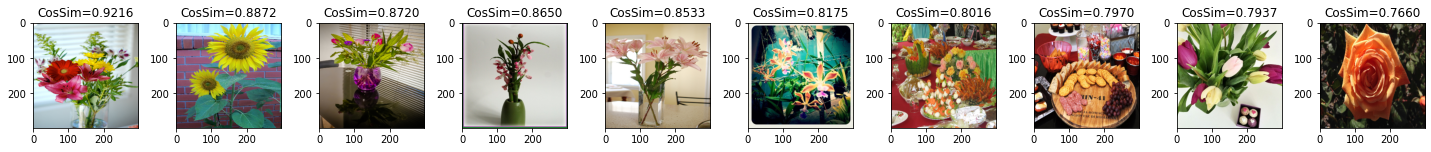



Query Text: A kitchen with some cabinets and stainless steel appliances.


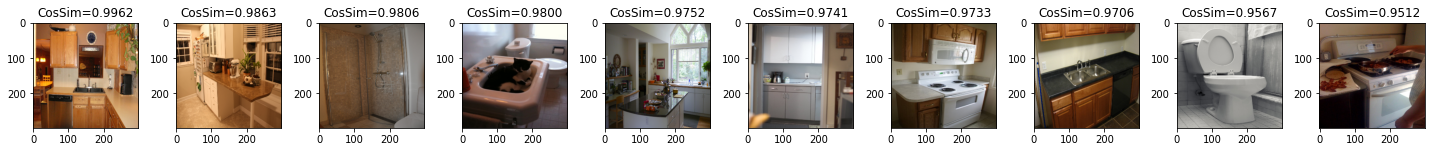



Query Text: A bunch of brightly colored candles lit up.


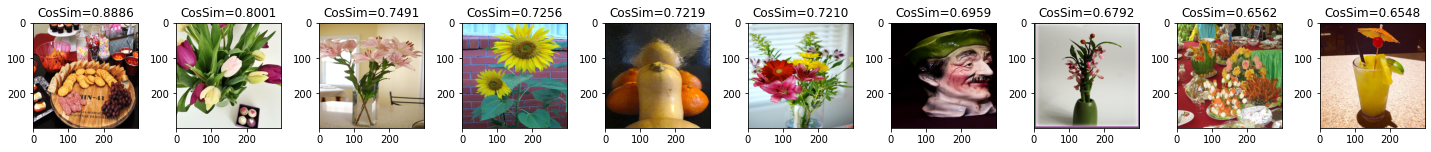



Query Text: A deck with deck furniture and flowers on the railing¬


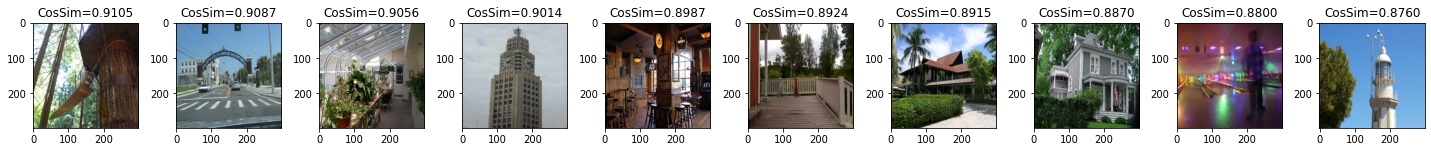



Query Text: Old peraon in stripe shirt and gray hair looking at a car


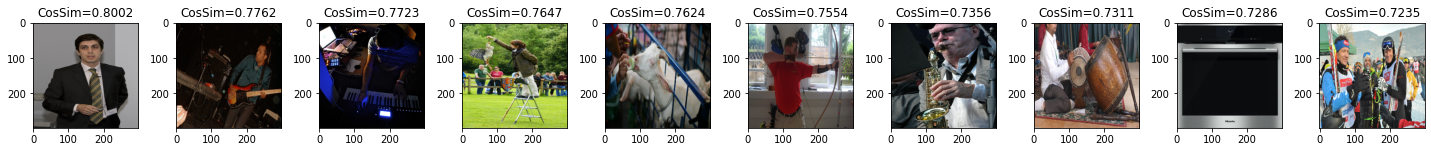

In [21]:
ImageFromText(sim_mat)

In [22]:
train_image_embeddings, train_text_embeddings = proj(TrainingDataset)
test_image_embeddings, test_text_embeddings = proj(TestDataset)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


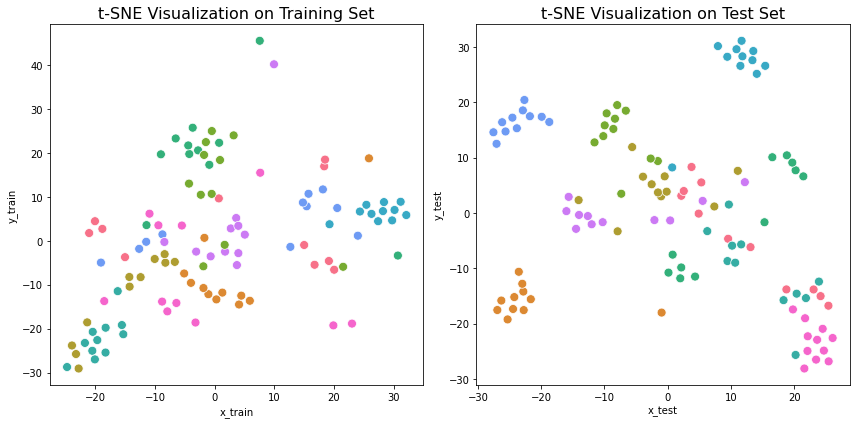

In [23]:
from sklearn.manifold import TSNE
import pandas as pd

num_classes = 10
random_idx = np.random.randint(0, len(train_image_embeddings), num_classes)
vis_array = np.empty((0, embed_dim))
label = []
for idx in random_idx:
    vis_array = np.vstack((vis_array, train_image_embeddings[idx]))
    label.append(idx)
    vis_array = np.vstack((vis_array, train_text_embeddings[idx * TrainingDataset.image_text_rate : (idx + 1) * TrainingDataset.image_text_rate]))
    label += ([idx] * TrainingDataset.image_text_rate)
label = np.array(label)
tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
tsne_out = tsne.fit_transform(vis_array)
tsne_df = pd.DataFrame(tsne_out, columns=["x_train", "y_train"])
tsne_df["label_train"] = label

random_idx = np.random.randint(0, len(test_image_embeddings), num_classes)
vis_array = np.empty((0, embed_dim))
label = []
for idx in random_idx:
    vis_array = np.vstack((vis_array, test_image_embeddings[idx]))
    label.append(idx)
    vis_array = np.vstack((vis_array, test_text_embeddings[idx * TestDataset.image_text_rate : (idx + 1) * TestDataset.image_text_rate]))
    label += ([idx] * TestDataset.image_text_rate)
label = np.array(label)
tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
tsne_out = tsne.fit_transform(vis_array)
tsne_df["x_test"] = tsne_out[:, 0]
tsne_df["y_test"] = tsne_out[:, 1]
tsne_df["label_test"] = label

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x="x_train", y="y_train", hue="label_train", palette=sns.color_palette("husl", num_classes), data=tsne_df, legend=False, s=80)
plt.title("t-SNE Visualization on Training Set", fontsize=16)
plt.subplot(1, 2, 2)
sns.scatterplot(x="x_test", y="y_test", hue="label_test", palette=sns.color_palette("husl", num_classes), data=tsne_df, legend=False, s=80)
plt.title("t-SNE Visualization on Test Set", fontsize=16)
plt.tight_layout()
plt.show()

Image-Text pairs from Training Data


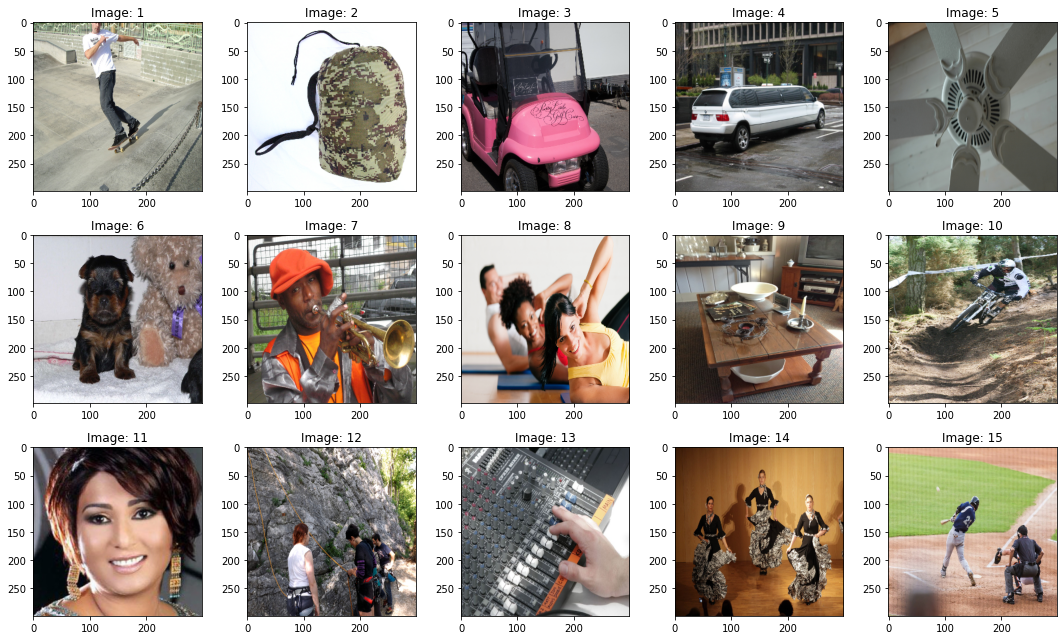

Text: 1 | negative : The man is in a red shirt and is holding a red paddle. 
Text: 2 | negative : A large black bird sits by itself on a log near a body of water.
Text: 3 | negative : A camera with an long zoom lens is sitting on the tripod.
Text: 4 | negative : A gray car is going down the road.
Text: 5 | negative : The canadian flag blowing in the wind. 
Text: 6 | negative : Bike racer wearing helmet racing down a street¬
Text: 7 | negative : A beekeeper pulls a tray out of the artificial beehive.
Text: 8 | positive : Two women and a man stretching on yoga mats.
Text: 9 | negative : A necklace over a person's chest holds the Superman logo.
Text: 10 | negative : The man is playing the large accordian in the place.
Text: 11 | negative : A woman wearing a leather dress with a red belt.
Text: 12 | negative : A black furry dog with a long snout.
Text: 13 | negative : A childrens toy display is bright and filled with toys.
Text: 14 | negative : A person wearing a miniskirt has a tattoo on 

In [24]:
# Dataset Sanity Check
def show15trainingsamples(batch):
    label_dic = {1: "positive", -1: "negative"}
    plt.figure(figsize=(15, 9))
    for i in range(15):
        if i < len(batch["labels"]):
            plt.subplot(3, 5, i + 1)
            img = train_images[batch["image_idx"][i]]
            img = np.flip(img, axis=-1)
            plt.imshow(img)
            plt.title("Image: " + str(i + 1))
    plt.tight_layout()
    plt.show()
    for i in range(15):
        if i < len(batch["labels"]):
            label = int(batch["labels"][i].cpu().numpy().tolist())
            print("Text: " + str(i + 1) + " | " + label_dic[label] + " : " + train_texts[batch["text_idx"][i]])

print("Image-Text pairs from Training Data")
for batch in trainloader:
    show15trainingsamples(batch)
    break

Image-Text pairs from Test Data


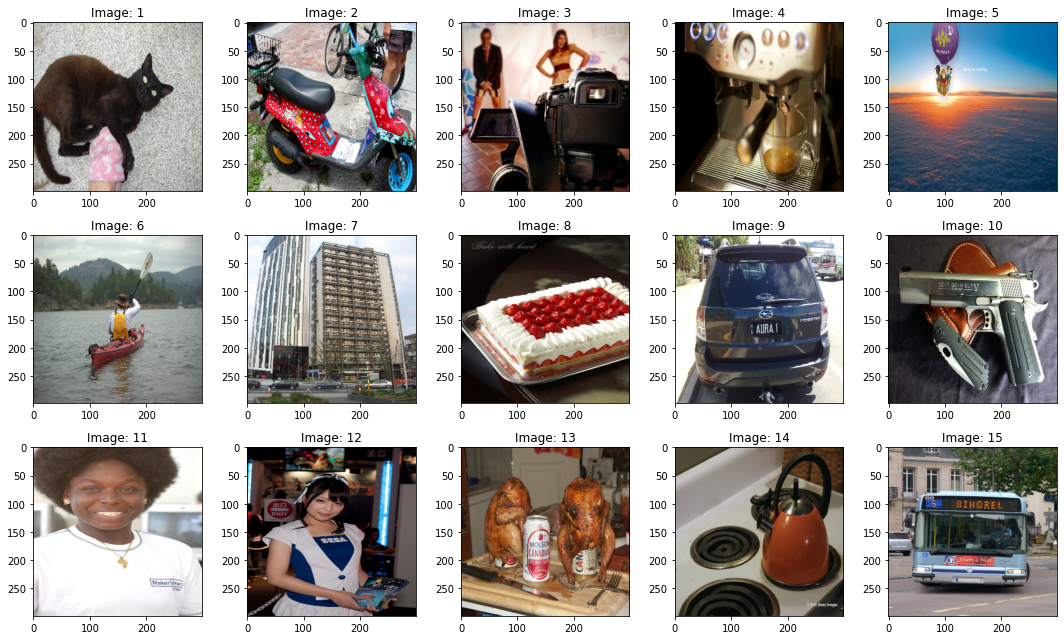

Text: 1 | negative : Fried meat is served along side a salad, a few potatoes and a drink. 
Text: 2 | negative : A very bright, orange squash next to a half of squash faced up with seeds.
Text: 3 | positive : A photographer taking photos of models advertising clothing.
Text: 4 | negative : A cake topped with strawberries sits in a glass container.
Text: 5 | negative : The kitchen appliances are positioned on the table.
Text: 6 | negative : A girl wearing a skirt is standing on a surfboard in front off a wave.
Text: 7 | negative : A person playing saxophone beside a person playing guitar
Text: 8 | negative : Someone is paddle boarding with a gray shirt and black pants.
Text: 9 | negative : A woman in a wedding dress standing next to plants.
Text: 10 | negative : six doughnuts placed in a plate and on a table 
Text: 11 | positive : a woman with a white t shirt and  gold necklace that is smiling
Text: 12 | negative : Tomatoes with cheese and herbs are being served.
Text: 13 | positive : Tw

In [25]:
def show15testsamples(batch):
    label_dic = {1: "positive", -1: "negative"}
    plt.figure(figsize=(15, 9))
    for i in range(15):
        if i < len(batch["labels"]):
            plt.subplot(3, 5, i + 1)
            img = test_images[batch["image_idx"][i]]
            img = np.flip(img, axis=-1)
            plt.imshow(img)
            plt.title("Image: " + str(i + 1))
    plt.tight_layout()
    plt.show()
    for i in range(15):
        if i < len(batch["labels"]):
            label = int(batch["labels"][i].cpu().numpy().tolist())
            print("Text: " + str(i + 1) + " | " + label_dic[label] + " : " + test_texts[batch["text_idx"][i]])

print("Image-Text pairs from Test Data")
for batch in testloader:
    show15testsamples(batch)
    break